In [5]:
import os
from sympy import im
from tnia.plotting.plt_helper import imshow_multi2d
from cellpose import models, io
from pathlib import Path
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np

## Create a make_label_image function

This function was started by Ian Coccimiglio in this thread https://forum.image.sc/t/creating-label-images-with-the-segment-anything-model-guide/93224

I added a couple of useful steps

1.  Sort masks by size, so we can render large masks first, small masks last, this prevents small masks from being overwritten by the large ones and we can see almost everything that was returned when the masks are rendered on a single 2D canvas. 

2.  Remove low intensities from mask.  This completely removes some masks that are background only, and removes background from other masks that are a mixture of background and foreground. 

In [162]:
from skimage import morphology, io

selem = morphology.disk(3)

def make_label_image(label_image, masks, orig_img, min_size, max_size, min_intensity=10):
    '''
    Creates a label image by adding one mask at a time onto an empty image, given the masks from an ultralytics prediction

    Inputs:
    - A label image of zeros, in the same size and shape of your original image.
    - A list of masks from an ultralytics segmentation
    Outputs:
    - A label-image of all masks
    '''

    # sort masks by size.  This is done so that small masked are rendered last, and are not overwritten by larger masks.
    sorted_masks = sorted(masks, key=lambda x: x.data.sum(), reverse=True)
    
    for enum, mask in enumerate(sorted_masks):
        mnarray = mask.data.cpu().numpy().squeeze()

        # remove low intensities from mask
        mnarray[orig_img<min_intensity] = 0
        pixels = orig_img[mnarray]

        if pixels.size == 0:
            continue

        mnarray = morphology.opening(mnarray, selem)
        if np.sum(mnarray) > min_size and np.sum(mnarray) < max_size:
            label_image[mnarray] = enum + 1 # set each mask to a unique ID (enum)

    return(label_image)

original min max 0 255


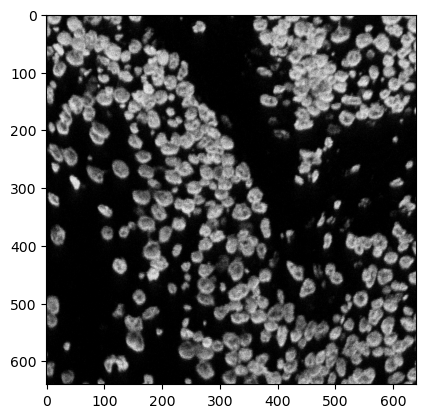

In [163]:
tnia_images_path = Path(r"D:\images")
parent_path=Path(tnia_images_path / r'tnia-python-images/imagesc/2024_03_21_nuclei_segmentation')

test_name='2023-03-28T14-12-32_Alessio_Pilot_Run_8bit.tif'
testim = imread(parent_path  / test_name) 
rgb_testim = np.zeros((testim.shape[0], testim.shape[1], 3), dtype=np.uint8)
rgb_testim[:,:,0] = testim
rgb_testim[:,:,1] = testim
rgb_testim[:,:,2] = testim

plt.imshow(testim, cmap="gray")
print('original min max', testim.min(), testim.max())

In [164]:
import logging
from ultralytics.models.sam import Predictor as SAMPredictor

# Create SAMPredictor
overrides = dict(conf=0.25, task='segment', mode='predict', imgsz=1024, model="mobile_sam.pt")
predictor = SAMPredictor(overrides=overrides)

logging.getLogger('ultralytics').setLevel(logging.CRITICAL) 

In [165]:
predictor.set_image(rgb_testim)
results = predictor(conf_thres=0.1, stability_score_thresh=0.1, crop_nms_thresh=0.5, points_stride=64)#points=points)#, labels=labels)
stop = 5

In [166]:
temp=results[0].orig_img.mean(axis=2)

In [167]:
import sys

labels_unfiltered = np.zeros(testim.shape[:2], dtype=np.uint16)
labels_unfiltered = make_label_image(labels_unfiltered, results[0].masks, temp, 0, testim.shape[0]*testim.shape[1], min_intensity=0)

labels = np.zeros(testim.shape[:2], dtype=np.uint16)
labels = make_label_image(labels, results[0].masks, temp, 0, 0.1*testim.shape[0]*testim.shape[1])

In [168]:
from skimage import io, measure

# relabel image
labels = measure.label(labels, connectivity=1)

# Calculate region properties
regions = measure.regionprops(labels)

# Define a threshold for solidity
solidity_threshold = 0.1

# Filter out labels with low solidity
labels_post_process = labels.copy()
for region in regions:
    if region.solidity < solidity_threshold or region.area < 50:
        labels_post_process[labels == region.label] = 0


In [169]:
import pandas as pd
points = pd.read_csv(parent_path / 'Results.csv')

In [170]:
import napari
viewer = napari.Viewer()
viewer.add_image(rgb_testim, name='testim')
viewer.add_labels(labels_unfiltered, name='labels unfiltered')
viewer.add_labels(labels, name='labels filtered')
viewer.add_labels(labels_post_process, name='labels post process')
points_layer = viewer.add_points(points[['Y', 'X']], size=4, face_color='blue', name='points')